# 3. Clustering results

## Setup

In [6]:
import os
import pickle
import re
import textwrap
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import bin.params as p
import bin.utils as u

In [7]:
sns.set_theme()
sns.set(rc={'figure.figsize':(12, 8)})

In [8]:
# papermill parameters
CLUSTERING_CHAINS = p.CLUSTERING_CHAINS
CHAINS = p.CHAINS

In [9]:
# non-papermill parameters
EXPERIMENT_SETTINGS = f'{CLUSTERING_CHAINS}_{CHAINS}'
METRIC_LABEL = 'mean % deviation for '
SIM_LABEL = '% similarity of sequences within one cluster'
TIME_LABEL = 'total time for given model splits fit+score (sec)'
YLL = 30
EXP_STRING = f'(scheme={p.FINAL_NUMBERING_SCHEME}, clustering={CLUSTERING_CHAINS}, chains={CHAINS}, dataset=TRAIN+VAL)'

In [10]:
EXPERIMENTS = [ 
    f'lco_whole_sequence_{EXPERIMENT_SETTINGS}',
    f'lco_cont_window_r0_{EXPERIMENT_SETTINGS}',
    f'lco_cont_window_r1_{EXPERIMENT_SETTINGS}',
    f'lco_cont_window_r2_{EXPERIMENT_SETTINGS}',
    f'lco_cont_window_r3_{EXPERIMENT_SETTINGS}',
    f'lco_cont_window_r4_{EXPERIMENT_SETTINGS}',
    f'lco_regional_simple_region_{EXPERIMENT_SETTINGS}',
    f'lco_regional_simple_region,position_{EXPERIMENT_SETTINGS}',
    f'lco_regional_simple_region,position,chain,species_{EXPERIMENT_SETTINGS}'
]

In [11]:
def get_record_identification(experiment_name):
    if 'whole_sequence' in experiment_name:
        return 'whole sequence (mean of means for all positions)'
    elif 'cont_window' in experiment_name:
        return 'all centered windows'
    elif 'regional_simple' in experiment_name:
        return 'all position records'
    else:
        return '???'

**Create the directory for result plots PNG files to be stored in:**

In [12]:
LCO_SUMMARY_PLOTS_DIR_PATH = f'{p.DATA_DIR}/png/lco_summaries'
command = f'mkdir -p {LCO_SUMMARY_PLOTS_DIR_PATH}'
! $command

**Create the directory for result CSV files to be stored in:**

In [13]:
LCO_SUMMARY_CSV_DIR_PATH = f'{p.DATA_DIR}/csv/lco_summaries'
command = f'mkdir -p {LCO_SUMMARY_CSV_DIR_PATH}'
! $command

**Some models have obscure result values and those reduce the plot readability. \
In certain scenarios where this is the case, we do not want to plot them:**

In [14]:
LINEAR_MODELS = ['linreg', 'lars', 'gradientboosting', 'BLknnwholeseqn10'] 
ADABOOSTS = ['adaboostMorN2', 'adaboostMorN5']

**Helper functions definitions:**

In [15]:
def wrap(text, n=YLL):
    return '\n'.join(textwrap.wrap(text, n))

In [16]:
def collect_data(experiment_name: str, 
                 ignore_models_plot: list = LINEAR_MODELS) -> tuple:
    
    results_folder_path = f'{p.DATA_DIR}/csv/{experiment_name}'
    result_files = [rf for rf in os.listdir(results_folder_path) if rf.endswith('.csv')]
    # jeden model - vela similarity filov
    # group by 'similarity' - in each of the files - compute average test_error 
    # create one summary dataset 'model','similarity', 'mean_error', 'split_number', 'training_time'
    split_dfs = []
    
    for result_file in result_files:
        result_file_basename = os.path.splitext(result_file)[0]
        similarity = re.findall(r'sim(\d+)', result_file_basename)[0]
        
        model = result_file_basename.split('_')[1]
        result_df = pd.read_csv(os.path.join(results_folder_path, result_file), index_col=0)
        result_df['similarity'] = int(similarity)
        split_dfs.append(result_df)
    #print('get partial dfs')

    results_all_splits_df = pd.concat(split_dfs, ignore_index=True)        
    results_all_splits_df['features'] = experiment_name
    
    groupby = results_all_splits_df.groupby(['model', 'similarity', 'features'])
    #print('groupby')

    grouped_by_sim_df = groupby.agg({'test_score': 'mean', 'fit_time':'sum', 'score_time': 'sum'}).reset_index()
    #print('agg')
    #return grouped_by_sim_df

    grouped_by_sim_df = grouped_by_sim_df[
        ~grouped_by_sim_df.model.isin(ignore_models_plot)].reset_index(drop=True)
    #print('filter ignores')
    grouped_by_sim_df['total_time(sec)'] = grouped_by_sim_df['fit_time'] + grouped_by_sim_df['score_time']
    #print('total_time')
    
    return results_all_splits_df, grouped_by_sim_df

In [17]:
def generate_plot(data_df: pd.DataFrame,
                  experiment_name: str, 
                  result_column: str = 'test_score',
                  plot_type: str = 'line',
                  xlabel: str = '',
                  ylabel: str = ''):    
    if plot_type == 'line':
        plot = sns.lineplot(data=data_df, x='similarity', y=result_column, 
                            hue='model', style='model', markers=True)
        if result_column == 'total_time(sec)': 
            plot.set_yscale('log')
        #plot.text(1, 0, s='BRASKO')
        #plot.text(10, 0, s='right')
    elif plot_type == 'violin':
        plot = sns.violinplot(data=data_df, x='model', y=result_column)
        for item in plot.get_xticklabels(): 
            item.set_rotation(90)
    else:
        raise ValueError('Invalid plot_type')
    
    plot.set_title(f'{experiment_name} - {result_column}')
    plot.set_xlabel(xlabel)
    plot.set_ylabel(ylabel)
    
    return plot

In [18]:
def add_baselines_to_data_sims(data_sims_df: pd.DataFrame) -> pd.DataFrame:
    if 'BLavgpos' in data_sims_df['model']:
        # baselines already present in the DataFrame, exit
        return data_sims_df
    
    
    X = collect_data(f'lco_whole_sequence_{EXPERIMENT_SETTINGS}')[1]
    baselines = [ bl for bl in X['model'].unique() if bl.startswith('BL') ]
    baselined_X = X[ X['model'].isin(baselines) ]

    merged_df = pd.concat([data_sims_df, baselined_X]).reset_index(drop=False)
    return merged_df

In [19]:
def generate_experiment_summaries(experiment_name: str, 
                                  ignore_models_plot: list = LINEAR_MODELS,
                                  plot=True) -> tuple:
    #print('start')
    data_splits_df, data_sims_df = collect_data(experiment_name, ignore_models_plot)
    #return collect_data(experiment_name, ignore_models_plot)
    #print('data collected')
    
    if plot:
        data_sims_df_with_bl = add_baselines_to_data_sims(data_sims_df)
        metric_x_label = f'{METRIC_LABEL} {get_record_identification(experiment_name)}'
        
        plot_score = generate_plot(data_sims_df_with_bl, experiment_name, 'test_score',
                                  xlabel=SIM_LABEL, ylabel=wrap(metric_x_label)); plt.show()
        #print('plot generated')
        plot_score.figure.savefig(f'{LCO_SUMMARY_PLOTS_DIR_PATH}/{experiment_name}_test_score_line.png')
        #print('test_score_line done')
        
        
        plot_score_v = generate_plot(data_sims_df_with_bl, experiment_name, 'test_score',
                                     plot_type='violin',
                                     xlabel='model', ylabel=wrap(metric_x_label)); plt.show()
        plot_score_v.figure.savefig(f'{LCO_SUMMARY_PLOTS_DIR_PATH}/{experiment_name}_test_score_violin.png')
        #print('test_score_violin done')
    
        plot_time = generate_plot(data_sims_df_with_bl, 
                                  experiment_name, 'total_time(sec)',
                                  xlabel=SIM_LABEL, ylabel=wrap(TIME_LABEL)); plt.show()
        plot_time.figure.savefig(f'{LCO_SUMMARY_PLOTS_DIR_PATH}/{experiment_name}_total_time_line.png')
        #print('test_time_line done')
    
    final_by_score_df = data_sims_df.groupby(['model', 'features'])['test_score'].mean().to_frame().sort_values(by='test_score')
    final_by_score_df.to_csv(f'{LCO_SUMMARY_CSV_DIR_PATH}/{experiment_name}_test_score.csv')
    #print('agg test_score done')
    
    # return data_sims_df
    
    final_by_time_df = data_sims_df.groupby(['model', 'features'])['total_time(sec)'].mean().to_frame().sort_values(by='total_time(sec)')
    final_by_time_df.to_csv(f'{LCO_SUMMARY_CSV_DIR_PATH}/{experiment_name}_total_time.csv')
    #print('agg total_time_done')
    
    return final_by_score_df, final_by_time_df

---

## Plots

**Generate score line plot, score violin plot and running time line plot for all the experiments listed at the top of the notebook (this may take a while):**

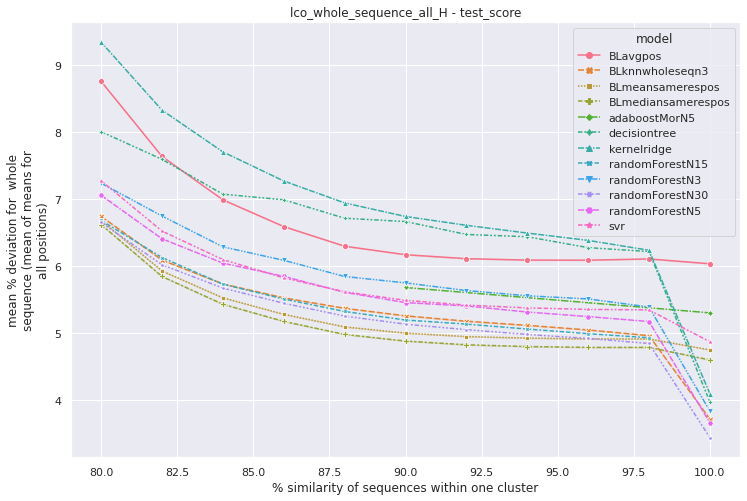

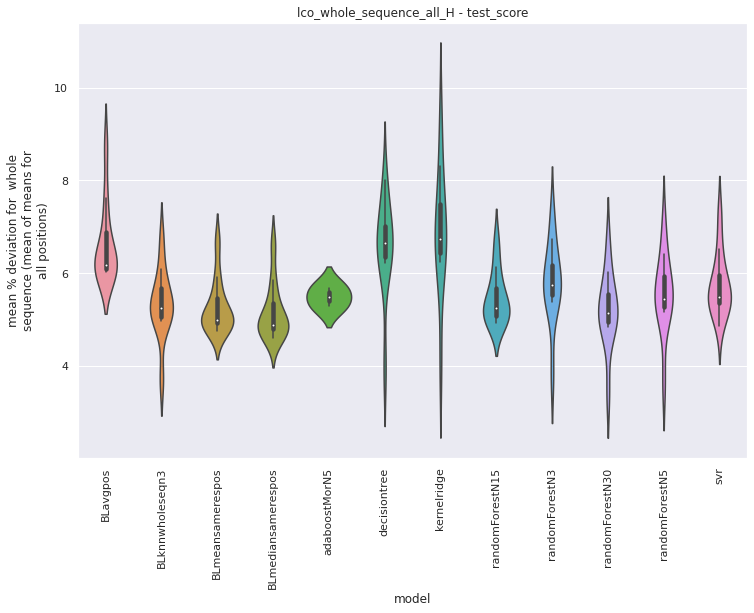

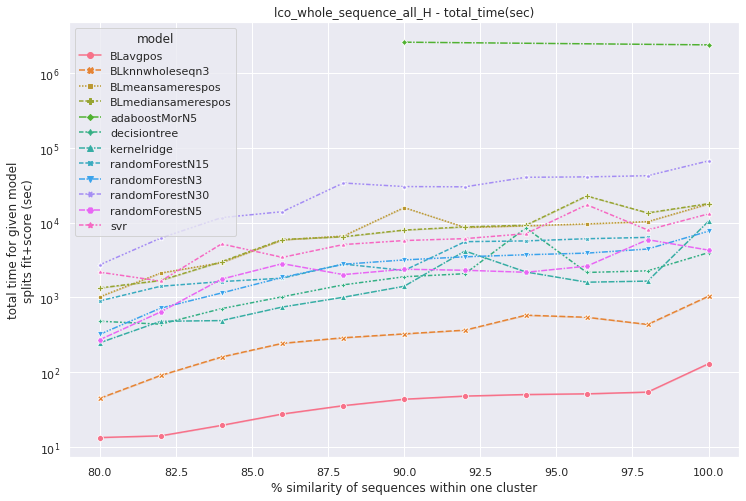

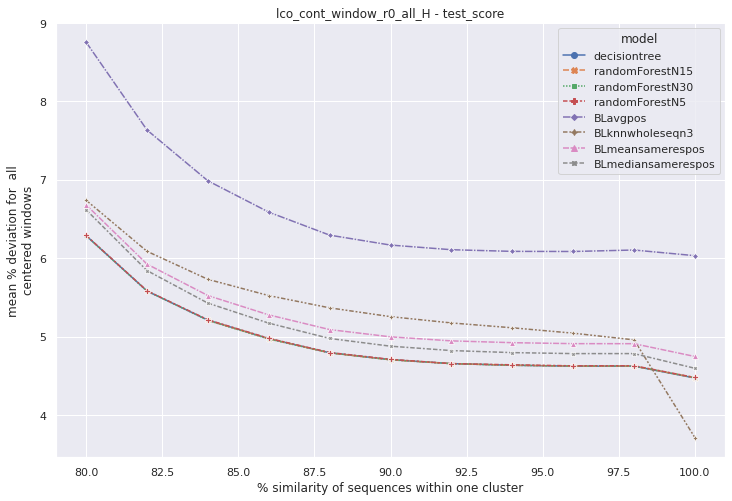

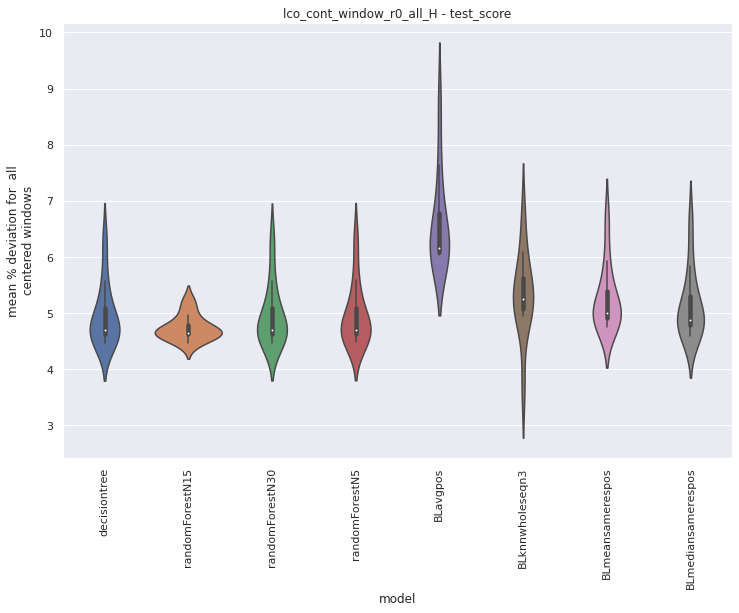

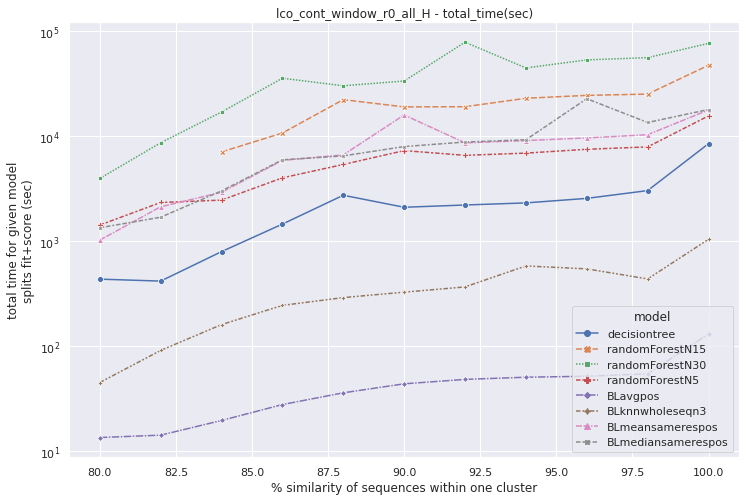

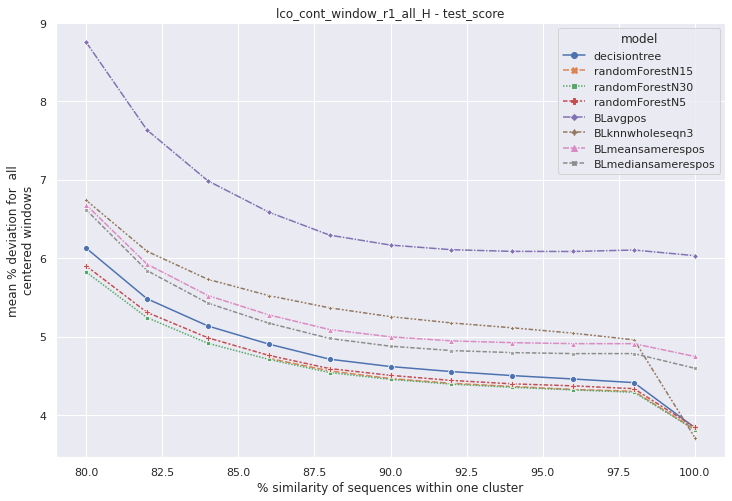

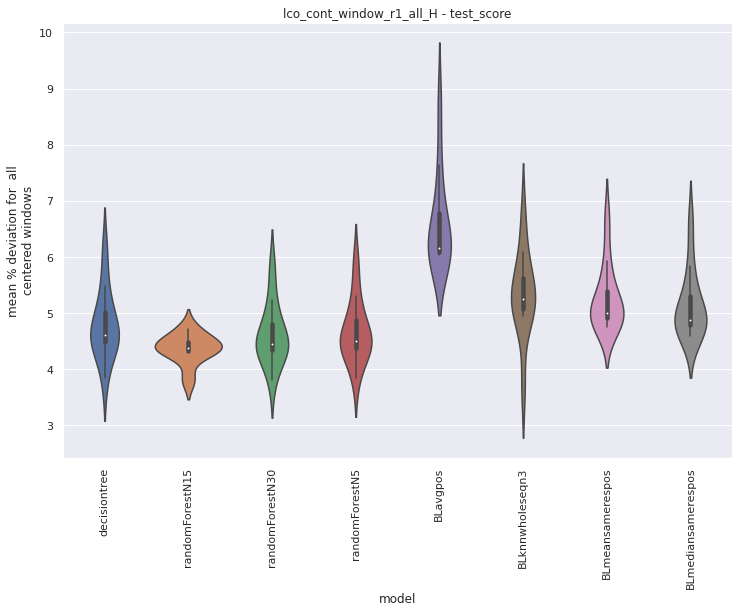

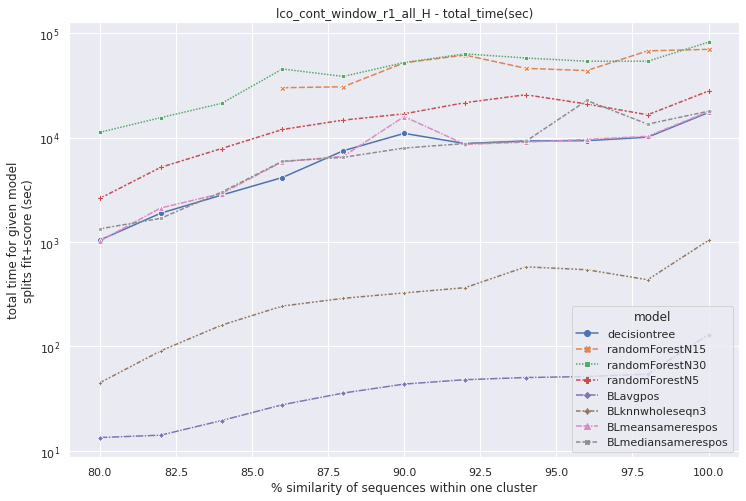

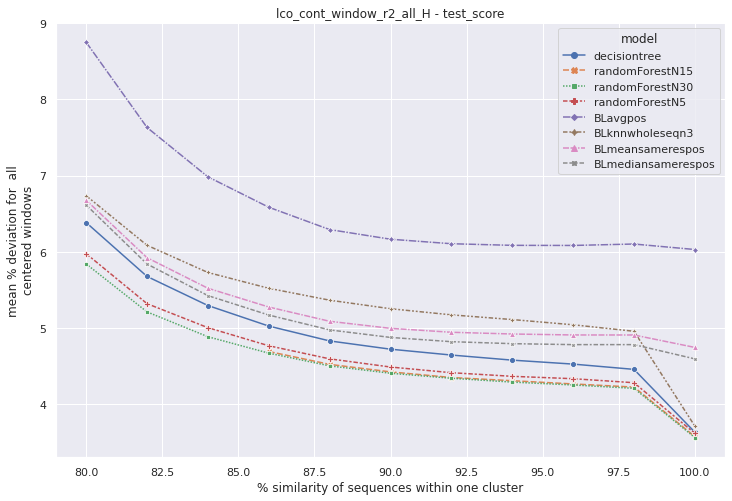

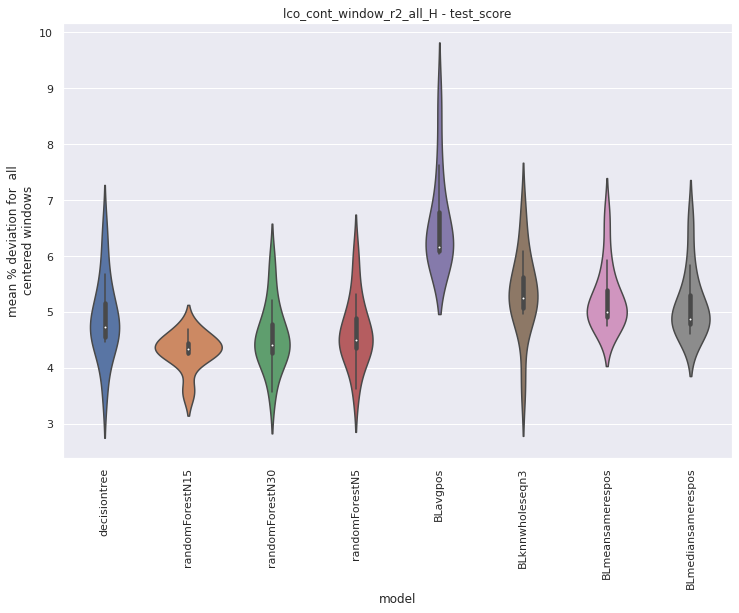

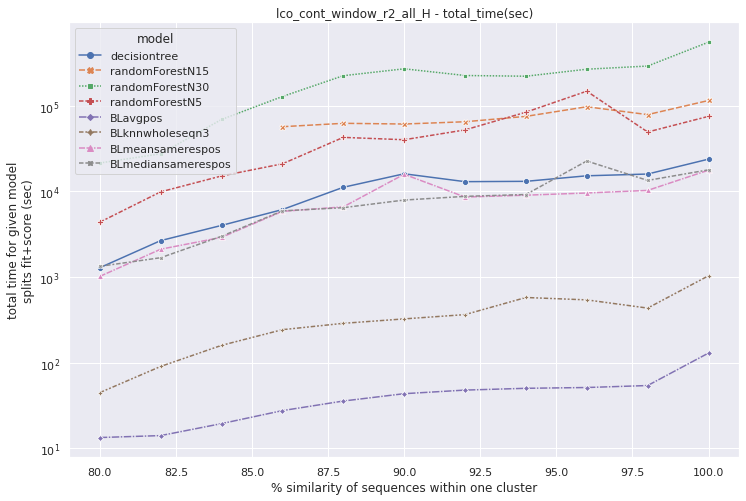

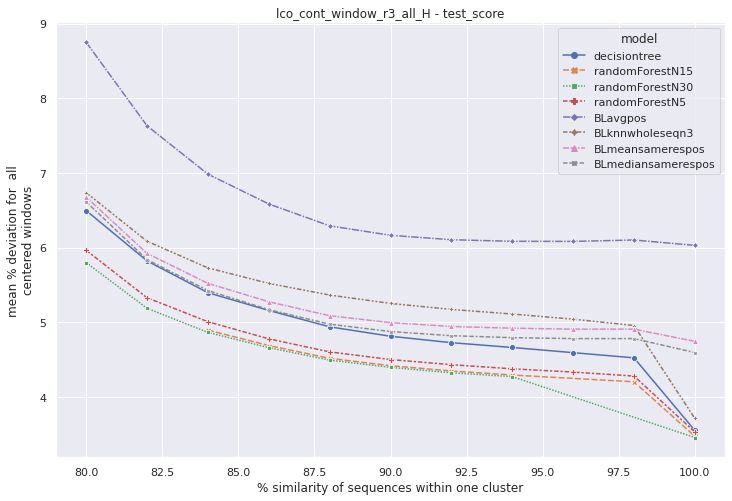

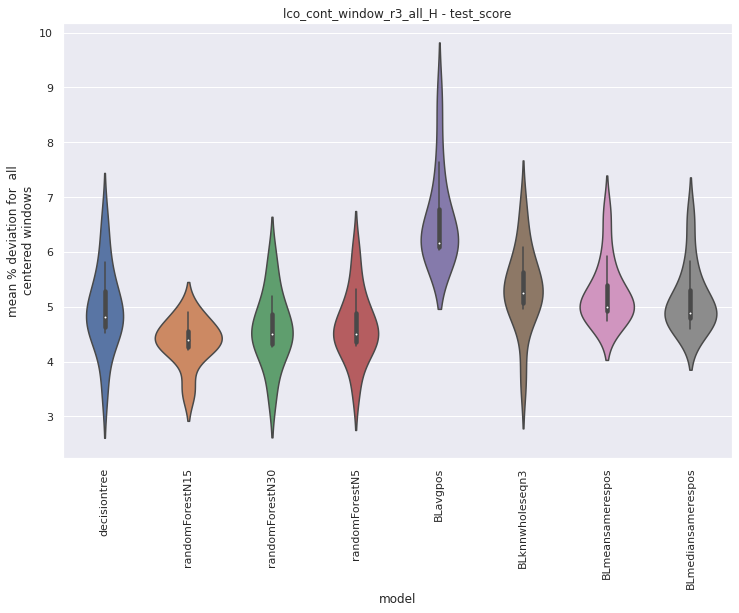

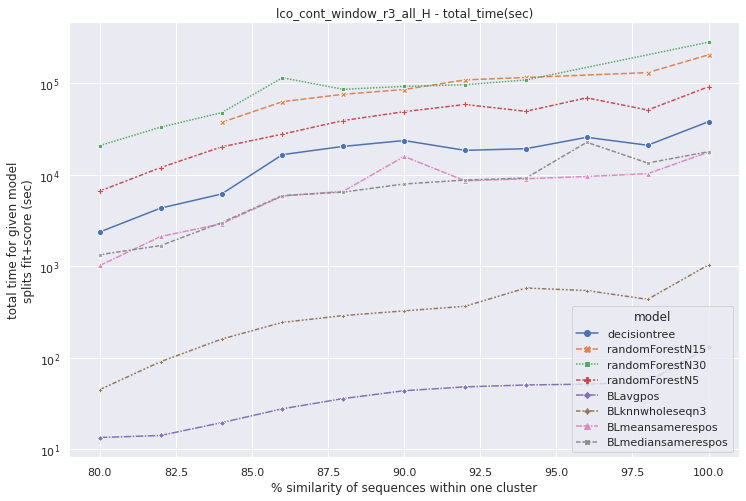

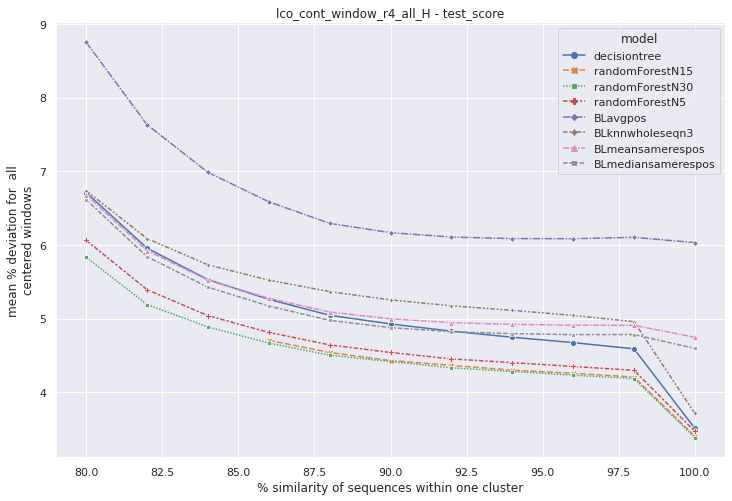

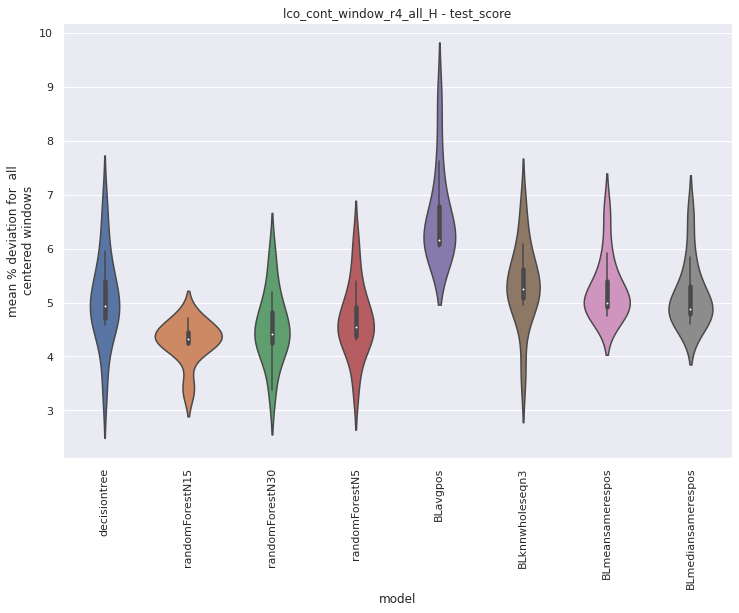

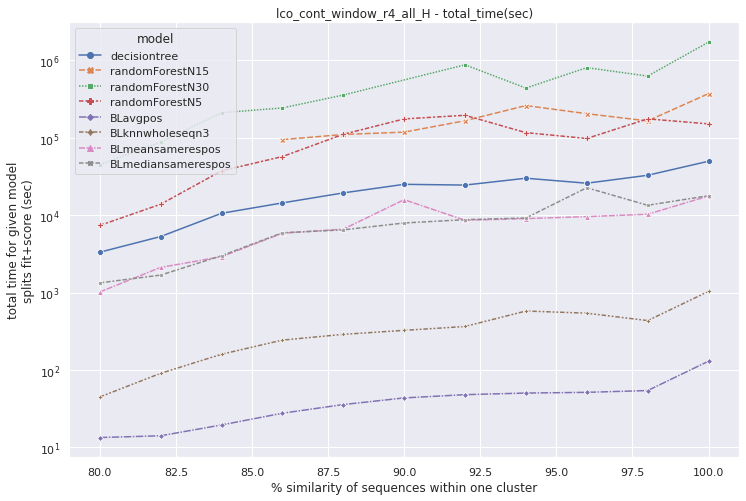

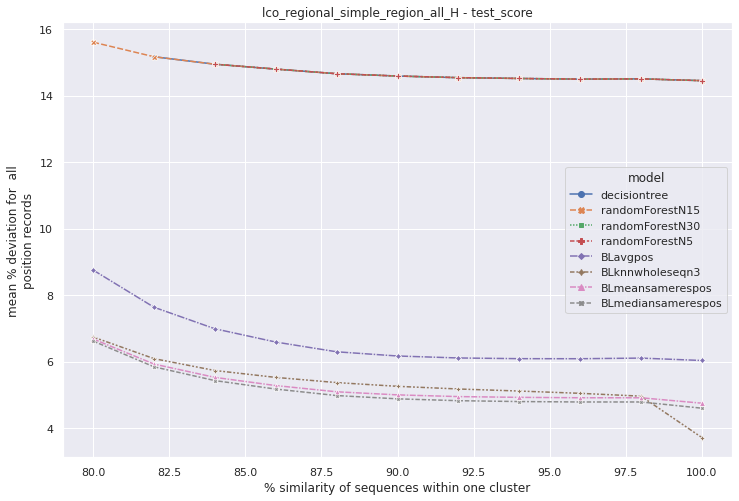

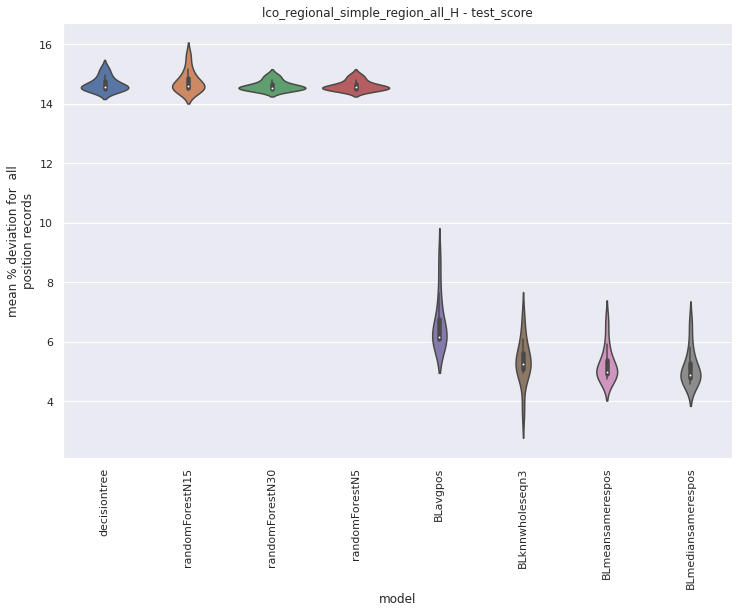

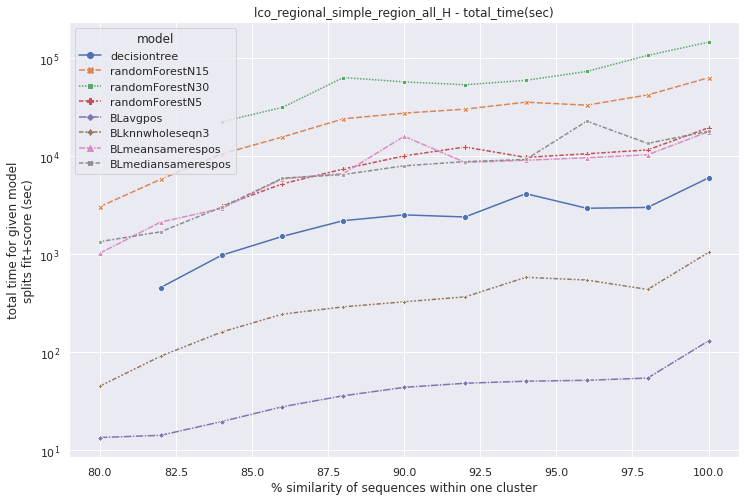

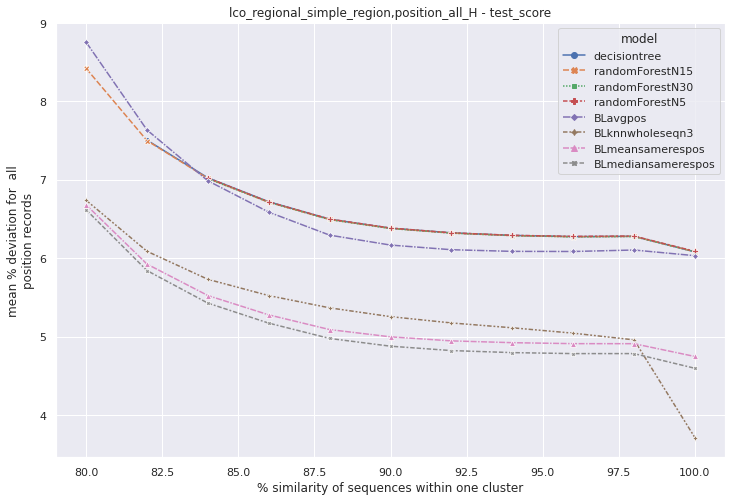

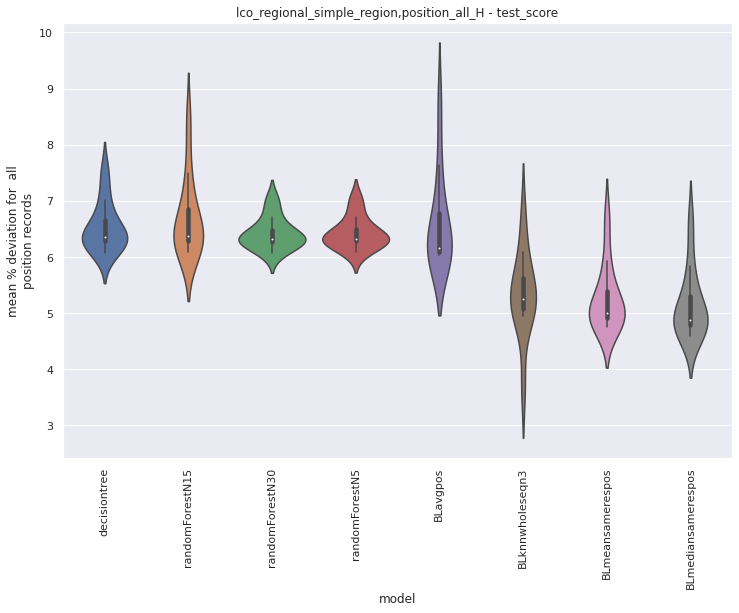

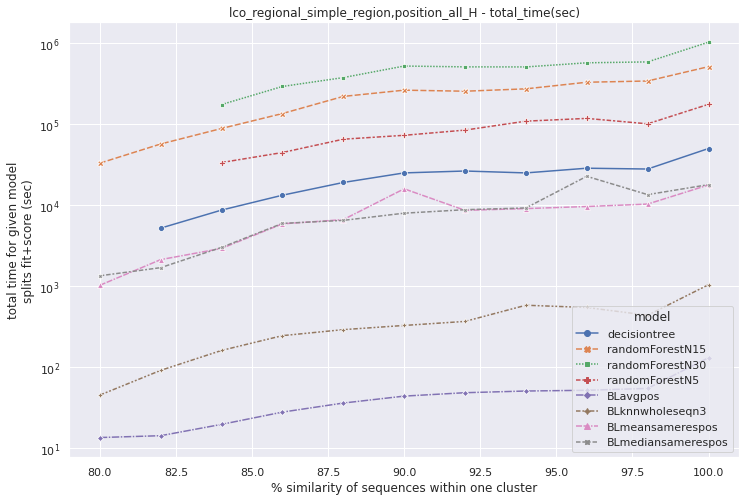

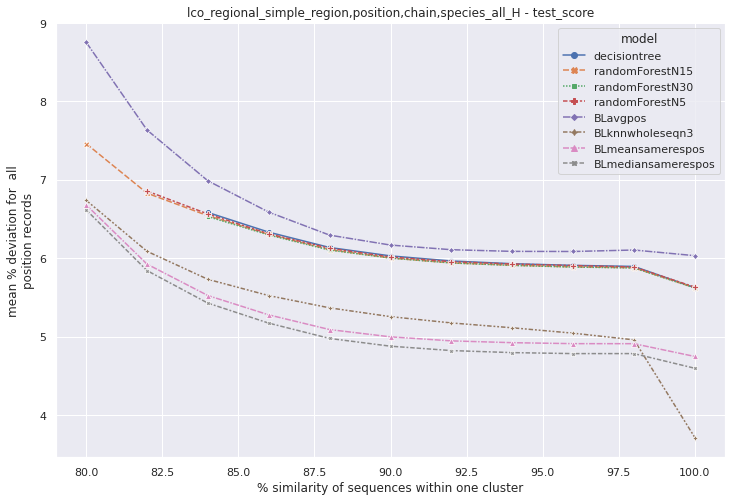

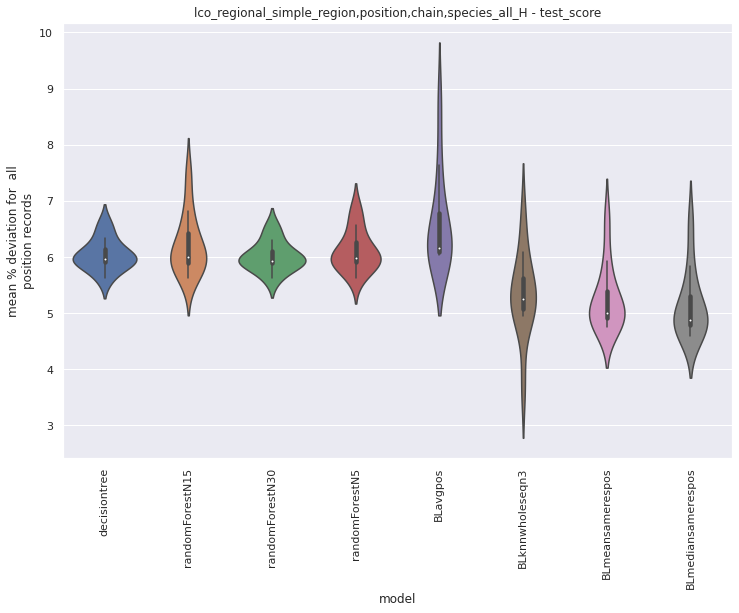

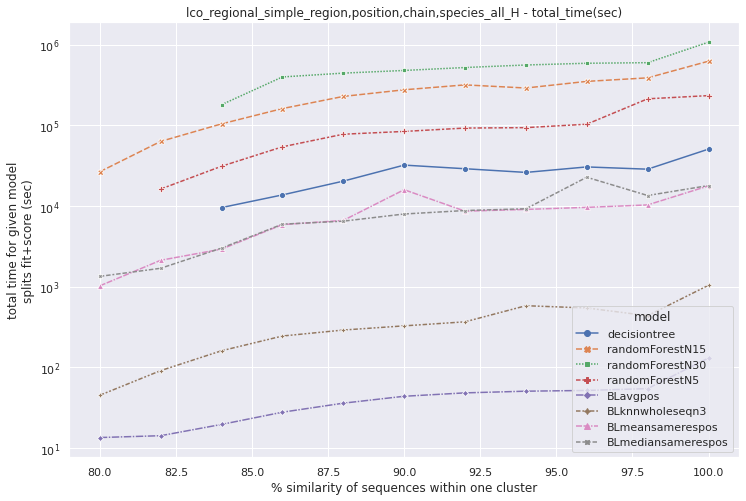

In [20]:
score_dfs, time_dfs = [], []

for experiment in EXPERIMENTS:
    ignore = ADABOOSTS if experiment.startswith('lco_cont_window_r') or experiment.startswith(
        'lco_regional_simple_') else LINEAR_MODELS
    score_df, time_df = generate_experiment_summaries(experiment, ignore)
    score_dfs.append(score_df)
    time_dfs.append(time_df)

___

## Fastest-run (model execution time) scenarios

**The total time is computed as a sum of execution times for all one-group-out CV trainings.**

In [21]:
time_df = pd.concat(time_dfs).sort_values(by='total_time(sec)').reset_index()
time_df.head(n=10)

,model,features,total_time(sec)
0,BLavgpos,lco_whole_sequence_all_H,44.419363
1,BLknnwholeseqn3,lco_whole_sequence_all_H,374.063358
2,kernelridge,lco_whole_sequence_all_H,2217.263933
3,decisiontree,lco_whole_sequence_all_H,2267.695468
4,decisiontree,lco_cont_window_r0_all_H,2405.534762
5,randomForestN5,lco_whole_sequence_all_H,2470.896554
6,decisiontree,lco_regional_simple_region_all_H,2606.346370
7,randomForestN3,lco_whole_sequence_all_H,3018.709895
8,randomForestN15,lco_whole_sequence_all_H,3450.807793
9,randomForestN5,lco_cont_window_r0_all_H,6107.440637


In [22]:
time_df.to_csv(f'{LCO_SUMMARY_CSV_DIR_PATH}/all_total_time_{EXPERIMENT_SETTINGS}.csv')

___

## Best result scenarios

In [23]:
score_df = pd.concat(score_dfs).sort_values(by='test_score').reset_index(drop=False).rename(columns={'test_score': 'mean absolute error'})
score_df.index = range(1, len(score_df)+1)
score_df.head(n=20)

,model,features,mean absolute error
1,randomForestN15,lco_cont_window_r4_all_H,4.275233
2,randomForestN15,lco_cont_window_r2_all_H,4.295890
3,randomForestN15,lco_cont_window_r3_all_H,4.355453
4,randomForestN15,lco_cont_window_r1_all_H,4.369608
5,randomForestN30,lco_cont_window_r4_all_H,4.549030
6,randomForestN30,lco_cont_window_r2_all_H,4.561506
7,randomForestN30,lco_cont_window_r3_all_H,4.606891
8,randomForestN30,lco_cont_window_r1_all_H,4.622182
9,randomForestN5,lco_cont_window_r3_all_H,4.649688
10,randomForestN5,lco_cont_window_r2_all_H,4.651674


In [24]:
score_df['features'].unique()

array(['lco_cont_window_r4_all_H', 'lco_cont_window_r2_all_H',
       'lco_cont_window_r3_all_H', 'lco_cont_window_r1_all_H',
       'lco_cont_window_r0_all_H', 'lco_whole_sequence_all_H',
       'lco_regional_simple_region,position,chain,species_all_H',
       'lco_regional_simple_region,position_all_H',
       'lco_regional_simple_region_all_H'], dtype=object)

In [25]:
score_df.to_csv(f'{LCO_SUMMARY_CSV_DIR_PATH}/all_test_score_{EXPERIMENT_SETTINGS}.csv')

___

## Clustering results analysis

### Whole sequence - baseline vs. sklearn

In [ ]:
score_df = pd.read_csv(f'{LCO_SUMMARY_CSV_DIR_PATH}/all_test_score_{EXPERIMENT_SETTINGS}.csv', index_col=0)
wholeseq_df = score_df[score_df['features'] == 'lco_whole_sequence_all_H']
wholeseq_df['model_type'] = np.where(wholeseq_df['model'].str.startswith('BL'), 'baseline', 'sklearn')

In [ ]:
wholeseq_df.head(n=1)

In [ ]:
plot = sns.barplot(data=wholeseq_df, x='model', y='mean absolute error', hue='model_type')
ylabel = wrap(METRIC_LABEL + get_record_identification('whole_sequence'))
_=u.annotate_plot(plot, x_rotation = 90, 
                  title='WHOLE_SEQUENCE clustering BASELINE vs. SKLEARN (dataset: TRAIN+VAL)', 
                  xlabel='model', ylabel=ylabel, show_bar_values=True)

What I see 
- baseline models perform better than non-baseline models
- although RF30 is very good as well
- the simplest baseline model actually performs worse than most of the sklearn models, at least that was expected

---

### WINDOW models vs. WHOLE_SEQUENCE

In [ ]:
import pandas as pd

In [ ]:
score_df = pd.read_csv(f'{LCO_SUMMARY_CSV_DIR_PATH}/all_test_score_{EXPERIMENT_SETTINGS}.csv', index_col=0)
score_df.head(n=20)


In [ ]:
def generate_scenario_id(row):
    scenario = ''
    f = row['features']
    if 'whole_sequence' in f:
        scenario = 'whole sequence'
    elif 'cont_window' in f:
        scenario = f'window {f.split("_")[3]}'
    elif 'regional_simple' in f:
        props = f.split('_')[3].split(',')
        scenario = ', '.join([prop[:3] for prop in props])
    return f'{row["model"]} X {scenario}'

In [ ]:
def extract_from_features(s):
    m = ''
    tokens = s.split('_')
    if 'whole' in s: m += 'whole sequence\n'
    elif 'window' in s: m += f'sliding window (radius={tokens[3][1:]})\nExtra: position'
    elif 'regional': m += f'sliding window (non-OH, radius=1)\nExtra: {tokens[3]}'
    return u.wrap(m, 30)

In [ ]:
score_df2 = score_df.copy()
score_df2['features'] = score_df2['features'].apply(extract_from_features)
#heatmap_models = ['decisiontree', 'randomForestN5', 'randomForestN15', 'randomForestN30']
heatmap_models = ['decisiontree', 'randomForestN5', 'randomForestN30']
#heatmap_models = score_df['model'].unique()
heatmap_data = score_df2[score_df2['model'].isin(heatmap_models)].pivot(
    'model', 'features', 'mean absolute error').reindex(index=heatmap_models)
heatmap_data

In [ ]:
sns.set(rc={'figure.figsize':(15, 9)})
plot = sns.heatmap(heatmap_data, cmap='rocket_r', robust=True, annot=True)
plot.set_title(f'model vs. features - MAE')
plot.figure.tight_layout()
plot.figure.savefig(f'{LCO_SUMMARY_PLOTS_DIR_PATH}/mean_score_heatmap_boxplot2_{EXPERIMENT_SETTINGS}.png')

In [ ]:
score_df

In [ ]:
score_df['scenario_type'] = np.where(score_df['features'] == f'lco_whole_sequence_{EXPERIMENT_SETTINGS}',
                                     'whole sequence', 'window')
score_df['scenario'] = score_df.apply(generate_scenario_id, axis=1)
plot = sns.barplot(data=score_df, x='features', y='mean absolute error', hue='scenario_type')
ylabel = wrap('Average % deviation for all records within given clustering scenario. For windowed scenarios one record is for one ANARCI position in one sequence, for whole sequence models one record is the whole chain sequence.', 50)
_=u.annotate_plot(plot, x_rotation = 90, 
                  title='WINDOW vs. WHOLE SEQUENCE models - clusterinig (dataset: TRAIN+VAL)', 
                  xlabel='scenario', ylabel=ylabel, show_bar_values=True, bar_decimals=1)


What I see 
- windowed models are usually better than whole sequence models
- big random forests are good with windowed representation
- model choice is more important than the choice of window radius
- whole sequence models are better than simple regional models 

---

## Prepare for the TEST dataset runs

**The next step in the pipeline is to train and predict on the `test` dataset.**

**Perform the following steps:**

**1. Run the following cells to print and generate list of scenarios that will be used for the TEST training and predictions:**

In [ ]:
n, scenarios = 0, []
for index_key, row in score_df.iterrows():
    if row['model'].startswith('BL') and 'whole_sequence' in row['features']:
        scenarios.append([row['model'], row['features']])
    elif n < p.HOW_MANY_BEST_NONBASELINES:
        scenarios.append([row['model'], row['features']])
        n += 1

In [ ]:
print('The scenarios that will be ran:')
for index, scenario in enumerate(scenarios):
    print(f'Scenario #{index+1} - model: {scenario[0]} experiment: {scenario[1]}')

In [ ]:
with open(f'{p.DATA_DIR}/pickles/test_scenarios.p', 'wb') as test_scenarios_file:
    pickle.dump(scenarios, test_scenarios_file)

**2. Run `test_training_all` Snakemake rule. That might take a while.**

**3. Run `test_predictions_all` Snakemake rule. That might take a while.**

**4. Check the results of training and prediction runs in `notebooks/reports/04_final_viz.ipynb` notebook.**